In this notebook following analysis is performed:
1. Comparison of the different water treatment trains based on the brine disposal method. Select minimum, maximum and medium cost treatment trains
2. Sensitivity of the LCOW of the treatment train to the treated volume for each treatment train selected in step 1
3. Sensitivity of the LCOW of the treatment train to the distance the brine needs to be transported for disposal

In [1]:
import pandas as pd
import numpy as np
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
import pyomo.util.infeasible as infeas
from idaes.core.util.model_statistics import *
import matplotlib.pyplot as plt
from truck_pipe_cost_functions import truck_costing, pipe_costing
from watertap3.utils.post_processing import get_results_table

Baseline test case

In [2]:
case_study = 'big_spring'
scenario = 'dwi_a'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.reverse_osmosis.membrane_area.unfix()
m.fs.reverse_osmosis.feed.pressure.unfix()

m.fs.big_spring_feed.flow_vol_in.fix(72037 * 6.30902e-5) #gpm to m3s
m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(0.698) #kg/m3
m.fs.well_field.lift_height.fix(174)

m.fs.costing_param.electricity_price = 0.0652
m = run_and_return_model(m, objective=True,print_it=True)
m, df = get_results_table(m=m, case_study='test', scenario=scenario)    
m.fs.costing.LCOW.value()


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

0.5231895634794616

In [21]:
(0.03577*4.54483 + 0.18993*4.54437 + 0.19989*4.31716 + 0.033*4.1543 + 0.0127*4.15388 + 0.02448*4.15347 + 0.02742* 0.40196)/4.153

0.5276144330363594

In [22]:
0.03577 + 0.18993 + 0.19989 + 0.033 + 0.0127 + 0.02448 + 0.02742

0.52319

In [23]:
m.fs.deep_well_injection.LCOW()

0.02741578800111538

In [24]:
m.fs.costing.capital_recovery_factor()

0.06505143508027657

Comparison of all the brine management methods

Sensitivity of LCOW to volume of water being treated- baseline case

In [25]:
case_study = 'big_spring'
scenario = 'dwi_a'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.reverse_osmosis.membrane_area.unfix()
m.fs.reverse_osmosis.feed.pressure.unfix()
LCOWList_dwi_a = np.array([])
flow_list = [0.075,0.5,1.5,2.25,4.5,0.075]
for flow in flow_list:
    print(flow)
    m.fs.big_spring_feed.flow_vol_in.fix(flow)
    m = run_and_return_model(m, objective=True)
    print(m.fs.costing.LCOW.value())
    LCOWList_dwi_a= np.concatenate((LCOWList_dwi_a,[m.fs.costing.LCOW.value()]))
m, df = get_results_table(m=m, case_study='high_flow', scenario=scenario)      
LCOWList_dwi_a
dwi_a_conc_flow = m.fs.deep_well_injection.flow_vol_in[0].value
dwi_a_total_water_recovery = m.fs.costing.system_recovery()
dwi_a_update_basis = (1-dwi_a_total_water_recovery)/dwi_a_total_water_recovery


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP


TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 0

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

BIG SPRING: DWI A
=========================SY

In [26]:
4.5*dwi_a_total_water_recovery

4.072283671304495

In [27]:
LCOWList_dwi_a

array([0.79091138, 0.61245141, 0.56458959, 0.55177917, 0.5339126 ,
       0.79091138])

Sensitivity of LCOW to volume of water being treated-medium cost case

In [28]:
case_study = 'big_spring'
scenario = 'zld_a'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'


m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.ro_first_stage.membrane_area.unfix()
m.fs.ro_first_stage.feed.pressure.unfix()
m.fs.ro_second_stage.membrane_area.unfix()
m.fs.ro_second_stage.feed.pressure.unfix()

LCOWList_zld_a = np.array([])
flow_list = [0.075,0.5,1.5,2.25,4.5]
for flow in flow_list:
    print(flow)
    m.fs.big_spring_feed.flow_vol_in.fix(flow)
    # m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(0.698)
    m = run_and_return_model(m, objective=True)
    LCOWList_zld_a= np.concatenate((LCOWList_zld_a,[m.fs.costing.LCOW.value()]))
m, df = get_results_table(m=m, case_study='high_flow', scenario=scenario)     
LCOWList_zld_a
zld_a_conc_flow = m.fs.landfill_zld.flow_vol_in[0].value
zld_a_total_water_recovery = m.fs.costing.system_recovery()
zld_a_update_basis = (1-zld_a_total_water_recovery)/zld_a_total_water_recovery


Case Study = BIG SPRING
Scenario = ZLD A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION


RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
EVAPORATION POND
MUNICIPAL DRINKING
LANDFILL ZLD


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = ZLD A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
EVAPORATION POND
MUNICIPAL DRINKING
LANDFILL ZLD

.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
..............

Sensitivity of LCOW to volume of water being treated- highest cost case

In [29]:
case_study = 'big_spring'
scenario = 'zld_c'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.ro_first_stage.membrane_area.unfix()
m.fs.ro_first_stage.feed.pressure.unfix()
m.fs.ro_second_stage.membrane_area.unfix()
m.fs.ro_second_stage.feed.pressure.unfix()

LCOWList_zld_c = np.array([])
flow_list = [4.5,0.5,1.5,2.25,4.5]
for flow in flow_list:
    print(flow)
    m.fs.big_spring_feed.flow_vol_in.fix(flow)
    m = run_and_return_model(m, objective=True,print_it=True)
    LCOWList_zld_c= np.concatenate((LCOWList_zld_c,[m.fs.costing.LCOW.value()]))
m, df = get_results_table(m=m, case_study='high_flow', scenario=scenario)     
LCOWList_zld_c
zld_c_conc_flow = m.fs.landfill_zld.flow_vol_in[0].value
zld_c_total_water_recovery = m.fs.costing.system_recovery()
zld_c_update_basis = (1-zld_c_total_water_recovery)/zld_c_total_water_recovery


Case Study = BIG SPRING
Scenario = ZLD C




=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
BRINE CONCENTRATOR
CRYSTALLIZER
MUNICIPAL DRINKING
LANDFILL ZLD


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = ZLD C


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
BRINE CONCENTRATOR
CRYSTALLIZER
MUNICIPAL DRINKING
LANDFILL ZLD

.................................



In [30]:
zld_a_total_water_recovery

0.9348111782800876

Plot LCOW sensitivity to flow for each treatment train train

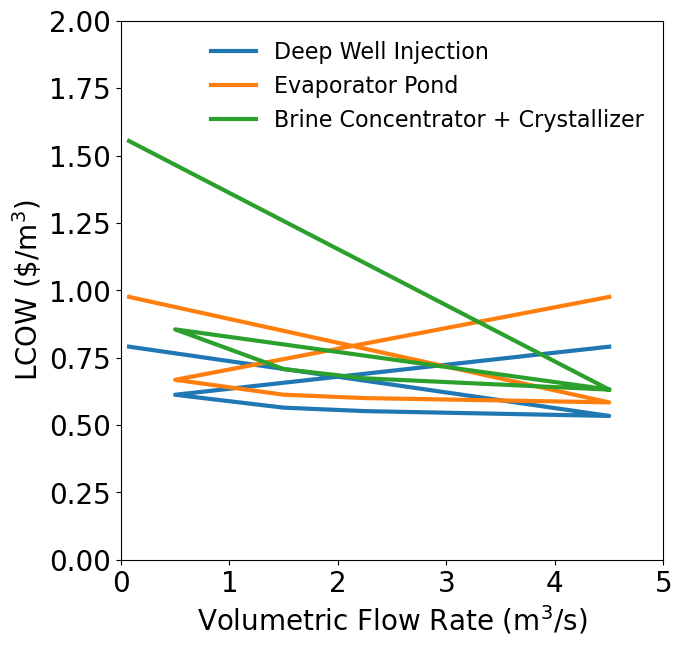

In [31]:
fig, ax = plt.subplots(figsize = (7,7))

ax.plot(flow_list,LCOWList_dwi_a, label = 'Deep Well Injection',linewidth = 3)
ax.plot(flow_list,LCOWList_zld_a, label = 'Evaporator Pond',linewidth = 3)
ax.plot(flow_list,LCOWList_zld_c, label = 'Brine Concentrator + Crystallizer',linewidth = 3)

ax.set_ylabel(r'LCOW (\$/m${^3}$)', fontsize = 20)
ax.set_xlabel(r'Volumetric Flow Rate (m${^3}$/s)', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_ylim([0,2])
ax.set_xlim([0,5])

ax.legend(fontsize = 16, frameon = False)

Transport cost as a function of mode, distance and volume

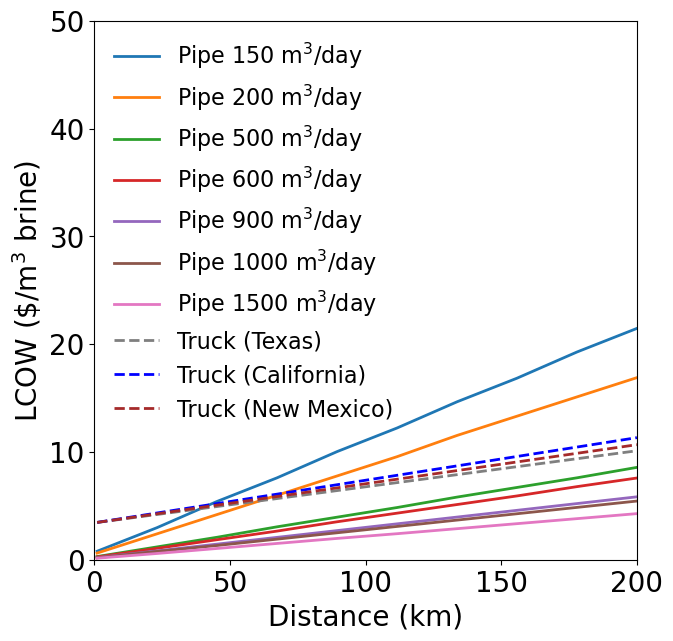

In [33]:
wacc = 0.1
plant_lifetime_yrs = 30

capital_recovery_factor = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
capital_recovery_factor

0.1060792482526339

Sensitivity check on deep well injection case with transport distance being varied:
1. This is the baseline cost case for the AMO project- verify this?
2. Default pipe transport cost is used

In [34]:
# Volume of concentrate in m3/s for input treatment volume 4.5 m3/s
print(dwi_a_conc_flow)
print(zld_a_conc_flow)
print(zld_c_conc_flow)

0.007294566779024324
0.0005017340478075308
0.0006427607617058318


In [35]:
# Calculate truck transport cost for alls cases
transport_costs = pd.DataFrame(columns=['process','capacity','distance','truck_cost ($/m3 brine)','pipe_cost ($/m3 brine)',
                                        'truck_tLCOW ($/m3 brine)','pipe_tLCOW ($/m3 brine)'])
# print(transport_costs)
distances = [0,10,20,50,100] # in km
capacity = {'dwi_a':dwi_a_conc_flow*3600*24,'zld_a':zld_a_conc_flow*3600*24,'zld_c':zld_c_conc_flow*3600*24}  # m3/day
LCOW = {'dwi_a':LCOWList_dwi_a[-1],'zld_a':LCOWList_zld_a[-1],'zld_c':LCOWList_zld_c[-1]}
total_water_recovery = {'dwi_a':dwi_a_total_water_recovery,'zld_a':zld_a_total_water_recovery,'zld_c':zld_c_total_water_recovery}

for case in ['dwi_a','zld_a','zld_c']:
    for d in distances:
        temp = {'process':case,'capacity': capacity[case],'distance':d,'truck_cost ($/m3 brine)': truck_costing(d),
        'pipe_cost ($/m3 brine)':pipe_costing(capacity[case],d) ,'truck_tLCOW ($/m3 brine)': LCOW[case]+truck_costing(d),
                'pipe_tLCOW ($/m3 brine)':LCOW[case]+pipe_costing(capacity[case],d)}
        # # print(temp)
        transport_costs=transport_costs.append(temp,ignore_index=True)

print(transport_costs)

   process    capacity distance truck_cost ($/m3 brine)  \
0    dwi_a  630.250570        0                       0   
1    dwi_a  630.250570       10                2.433973   
2    dwi_a  630.250570       20                2.768151   
3    dwi_a  630.250570       50                3.770683   
4    dwi_a  630.250570      100                5.441569   
5    zld_a   43.349822        0                       0   
6    zld_a   43.349822       10                2.433973   
7    zld_a   43.349822       20                2.768151   
8    zld_a   43.349822       50                3.770683   
9    zld_a   43.349822      100                5.441569   
10   zld_c   55.534530        0                       0   
11   zld_c   55.534530       10                2.433973   
12   zld_c   55.534530       20                2.768151   
13   zld_c   55.534530       50                3.770683   
14   zld_c   55.534530      100                5.441569   

   pipe_cost ($/m3 brine)  truck_tLCOW ($/m3 brine)  pi

Treatment sensitivity to transport plots

In [36]:
# Deep well injection
# Getting each unit process for treatment train
df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/high_flow_dwi_a.csv')
units = df['Unit Process Name'].unique() 
units = np.append(units,'Distance')

data_dwi_a = pd.DataFrame( columns = units[1::])

for d in distances:
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    new_row= np.append(new_row,d)
    new_row = new_row.reshape((1,8))

    temp = pd.DataFrame(new_row , columns = units[1::],index = ['dwi_a'] )
    data_dwi_a= pd.concat([data_dwi_a,temp])

data_dwi_a.reset_index(inplace=True)
data_dwi_a = data_dwi_a.rename(columns={'index':'scenario'})
print(data_dwi_a)


  scenario  Well Field  Microfiltration  Reverse Osmosis    UV/AOP  \
0    dwi_a    0.032991         0.189658         0.232333  0.177236   
1    dwi_a    0.032991         0.189658         0.232333  0.177236   
2    dwi_a    0.032991         0.189658         0.232333  0.177236   
3    dwi_a    0.032991         0.189658         0.232333  0.177236   
4    dwi_a    0.032991         0.189658         0.232333  0.177236   

   Treated Storage  Municipal Drinking  Deep Well Injection  Distance  
0         0.040042            0.024457             0.094195       0.0  
1         0.040042            0.024457             0.094195      10.0  
2         0.040042            0.024457             0.094195      20.0  
3         0.040042            0.024457             0.094195      50.0  
4         0.040042            0.024457             0.094195     100.0  


In [37]:
print(dwi_a_update_basis)
print(zld_a_update_basis)
print(zld_c_update_basis)

0.10503107426170348
0.06973474775927478
0.061515305492956994


In [38]:
temp=[]
for d in distances:
    temp_tranport = (transport_costs.loc[transport_costs['process']=='dwi_a'].loc[transport_costs['distance']== d]['pipe_cost ($/m3 brine)'].values[0])*dwi_a_update_basis
    temp.append(temp_tranport)
    

data_dwi_a['Transport']=temp
data_dwi_a

,scenario,Well Field,Microfiltration,Reverse Osmosis,UV/AOP,Treated Storage,Municipal Drinking,Deep Well Injection,Distance,Transport
0,dwi_a,0.032991,0.189658,0.232333,0.177236,0.040042,0.024457,0.094195,0.0,0.000000
1,dwi_a,0.032991,0.189658,0.232333,0.177236,0.040042,0.024457,0.094195,10.0,0.056765
2,dwi_a,0.032991,0.189658,0.232333,0.177236,0.040042,0.024457,0.094195,20.0,0.097099
3,dwi_a,0.032991,0.189658,0.232333,0.177236,0.040042,0.024457,0.094195,50.0,0.205400
4,dwi_a,0.032991,0.189658,0.232333,0.177236,0.040042,0.024457,0.094195,100.0,0.394370


Text(0.5, 1.0, 'Deep Well Injection')

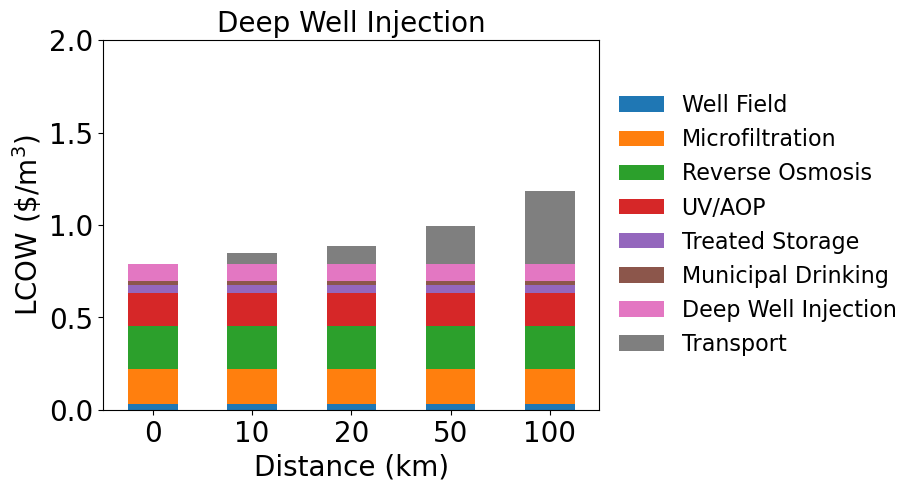

<Figure size 1000x700 with 0 Axes>

In [39]:
ax = data_dwi_a[[ 'Well Field', 'Microfiltration', 'Reverse Osmosis', 'UV/AOP',
 'Treated Storage', 'Municipal Drinking' ,'Deep Well Injection' ,'Transport','Distance']].plot.bar(x='Distance',stacked = True)
plt.figure(figsize=(10,7))
ax.set_ylim([0,2])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Distance (km)',fontsize =20)
ax.set_ylabel(r'LCOW (\$/m${^3}$)',fontsize =20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16,frameon=False)
ax.set_title('Deep Well Injection',fontsize =20)


In [40]:
# ZLD a
# Getting each unit process for treatment train
df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/high_flow_zld_a.csv')
# df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_zld_a.csv')
units = df['Unit Process Name'].unique() 
units = np.append(units,'Distance')

data_zld_a = pd.DataFrame( columns = units[1::])

for d in distances:
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    new_row= np.append(new_row,d)
    new_row = new_row.reshape((1,14))

    temp = pd.DataFrame(new_row , columns = units[1::],index = ['zld_a'] )
    data_zld_a= pd.concat([data_zld_a,temp])

data_zld_a.reset_index(inplace=True)
data_zld_a = data_zld_a.rename(columns={'index':'scenario'})
print(data_zld_a)


  scenario  Well Field  Microfiltration  RO First Stage  Passthrough    Ozone  \
0    zld_a    0.031937           0.1836        0.219233          0.0  0.18134   
1    zld_a    0.031937           0.1836        0.219233          0.0  0.18134   
2    zld_a    0.031937           0.1836        0.219233          0.0  0.18134   
3    zld_a    0.031937           0.1836        0.219233          0.0  0.18134   
4    zld_a    0.031937           0.1836        0.219233          0.0  0.18134   

   Bio Active Filtration  Lime Softening  RO Second Stage    UV/AOP  \
0               0.007316        0.042541         0.022456  0.173736   
1               0.007316        0.042541         0.022456  0.173736   
2               0.007316        0.042541         0.022456  0.173736   
3               0.007316        0.042541         0.022456  0.173736   
4               0.007316        0.042541         0.022456  0.173736   

   Treated Storage  Evaporation Pond  Municipal Drinking  Landfill ZLD  \
0         0.

In [41]:
temp=[]
for d in distances:
    temp_tranport =(transport_costs.loc[transport_costs['process']=='zld_a'].loc[transport_costs['distance']== d]['truck_cost ($/m3 brine)'].values[0])*(zld_a_update_basis)
    temp.append(temp_tranport)

data_zld_a['Transport (Truck)']=temp
data_zld_a

,scenario,Well Field,Microfiltration,RO First Stage,Passthrough,Ozone,Bio Active Filtration,Lime Softening,RO Second Stage,UV/AOP,Treated Storage,Evaporation Pond,Municipal Drinking,Landfill ZLD,Distance,Transport (Truck)
0,zld_a,0.031937,0.1836,0.219233,0.0,0.18134,0.007316,0.042541,0.022456,0.173736,0.039681,0.047896,0.024423,0.001398,0.0,0.000000
1,zld_a,0.031937,0.1836,0.219233,0.0,0.18134,0.007316,0.042541,0.022456,0.173736,0.039681,0.047896,0.024423,0.001398,10.0,0.169733
2,zld_a,0.031937,0.1836,0.219233,0.0,0.18134,0.007316,0.042541,0.022456,0.173736,0.039681,0.047896,0.024423,0.001398,20.0,0.193036
3,zld_a,0.031937,0.1836,0.219233,0.0,0.18134,0.007316,0.042541,0.022456,0.173736,0.039681,0.047896,0.024423,0.001398,50.0,0.262948
4,zld_a,0.031937,0.1836,0.219233,0.0,0.18134,0.007316,0.042541,0.022456,0.173736,0.039681,0.047896,0.024423,0.001398,100.0,0.379466


Text(0.5, 1.0, 'Evaporation Pond + Landfill\n(MLD)')

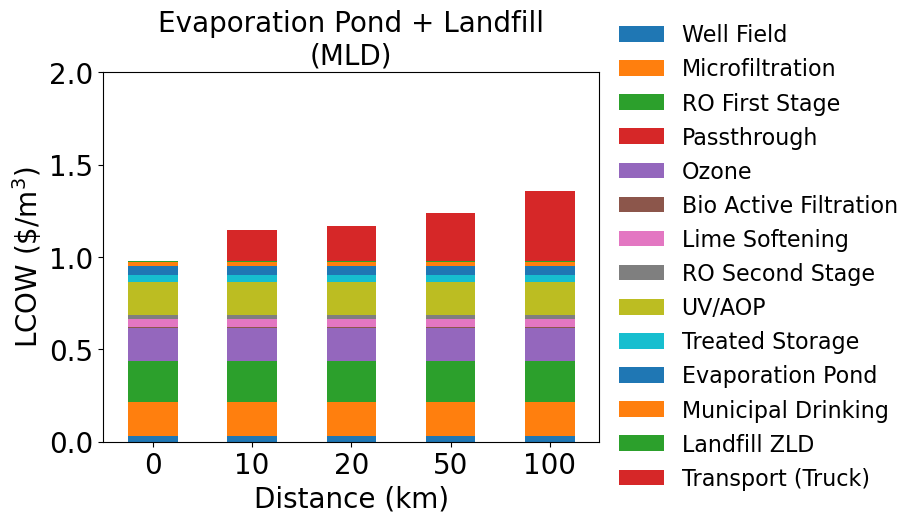

<Figure size 1000x700 with 0 Axes>

In [42]:
ax = data_zld_a[[ 'Well Field', 'Microfiltration', 'RO First Stage',
       'Passthrough', 'Ozone', 'Bio Active Filtration', 'Lime Softening',
       'RO Second Stage', 'UV/AOP', 'Treated Storage', 'Evaporation Pond',
       'Municipal Drinking', 'Landfill ZLD', 'Transport (Truck)','Distance']].plot.bar(x='Distance',stacked = True)
plt.figure(figsize=(10,7))
ax.set_ylim([0,2])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Distance (km)',fontsize =20)
ax.set_ylabel(r'LCOW (\$/m${^3}$)',fontsize = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16, frameon=False)
ax.set_title('Evaporation Pond + Landfill\n(MLD)',fontsize=20)

In [43]:
LCOWList_zld_a[-1]+0.382709

1.3582663697338344

In [44]:
# ZLD c
# Getting each unit process for treatment train
df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/high_flow_zld_c.csv')
units = df['Unit Process Name'].unique() 
units = np.append(units,'Distance')

data_zld_c = pd.DataFrame( columns = units[1::])

for d in distances:
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    new_row= np.append(new_row,d)
    new_row = new_row.reshape((1,15))

    temp = pd.DataFrame(new_row , columns = units[1::],index = ['zld_c'] )
    data_zld_c= pd.concat([data_zld_c,temp])

data_zld_c.reset_index(inplace=True)
data_zld_c = data_zld_c.rename(columns={'index':'scenario'})
print(data_zld_c)


  scenario  Well Field  Microfiltration  RO First Stage  Passthrough  \
0    zld_c    0.031692         0.182189        0.190326          0.0   
1    zld_c    0.031692         0.182189        0.190326          0.0   
2    zld_c    0.031692         0.182189        0.190326          0.0   
3    zld_c    0.031692         0.182189        0.190326          0.0   
4    zld_c    0.031692         0.182189        0.190326          0.0   

      Ozone  Bio Active Filtration  Lime Softening  RO Second Stage    UV/AOP  \
0  0.179978               0.010132        0.070094         0.008922  0.167036   
1  0.179978               0.010132        0.070094         0.008922  0.167036   
2  0.179978               0.010132        0.070094         0.008922  0.167036   
3  0.179978               0.010132        0.070094         0.008922  0.167036   
4  0.179978               0.010132        0.070094         0.008922  0.167036   

   Treated Storage  Brine Concentrator  Crystallizer  Municipal Drinking  \
0   

In [45]:
temp=[]
for d in distances:
    temp_tranport = (transport_costs.loc[transport_costs['process']=='zld_c'].loc[transport_costs['distance']== d]['truck_cost ($/m3 brine)'].values[0])*((zld_c_update_basis))
    temp.append(temp_tranport)

data_zld_c['Transport (Truck)']=temp

data_zld_c

,scenario,Well Field,Microfiltration,RO First Stage,Passthrough,Ozone,Bio Active Filtration,Lime Softening,RO Second Stage,UV/AOP,Treated Storage,Brine Concentrator,Crystallizer,Municipal Drinking,Landfill ZLD,Distance,Transport (Truck)
0,zld_c,0.031692,0.182189,0.190326,0.0,0.179978,0.010132,0.070094,0.008922,0.167036,0.039595,0.446421,0.201878,0.024415,0.001455,0.0,0.000000
1,zld_c,0.031692,0.182189,0.190326,0.0,0.179978,0.010132,0.070094,0.008922,0.167036,0.039595,0.446421,0.201878,0.024415,0.001455,10.0,0.149727
2,zld_c,0.031692,0.182189,0.190326,0.0,0.179978,0.010132,0.070094,0.008922,0.167036,0.039595,0.446421,0.201878,0.024415,0.001455,20.0,0.170284
3,zld_c,0.031692,0.182189,0.190326,0.0,0.179978,0.010132,0.070094,0.008922,0.167036,0.039595,0.446421,0.201878,0.024415,0.001455,50.0,0.231955
4,zld_c,0.031692,0.182189,0.190326,0.0,0.179978,0.010132,0.070094,0.008922,0.167036,0.039595,0.446421,0.201878,0.024415,0.001455,100.0,0.334740


In [46]:
LCOWList_zld_c[-1]#+0.286637

1.5541327107467406

In [47]:
units

array(['System', 'Well Field', 'Microfiltration', 'RO First Stage',
       'Passthrough', 'Ozone', 'Bio Active Filtration', 'Lime Softening',
       'RO Second Stage', 'UV/AOP', 'Treated Storage',
       'Brine Concentrator', 'Crystallizer', 'Municipal Drinking',
       'Landfill ZLD', 'Distance'], dtype=object)

Text(0.5, 1.0, 'Brine Concentrator + Crystallizer + \nLandfill (ZLD)')

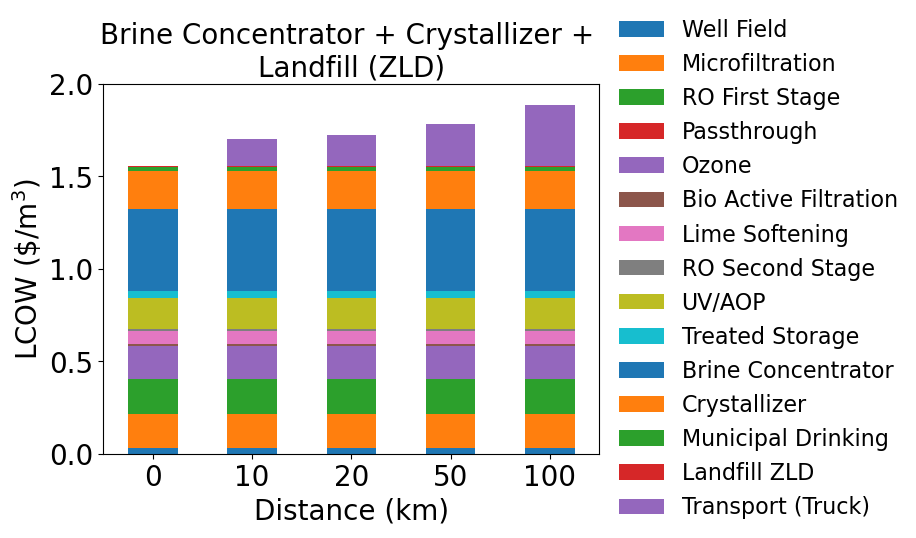

<Figure size 1000x700 with 0 Axes>

In [48]:
ax = data_zld_c[[ 'Well Field', 'Microfiltration', 'RO First Stage',
       'Passthrough', 'Ozone', 'Bio Active Filtration', 'Lime Softening',
       'RO Second Stage', 'UV/AOP', 'Treated Storage', 'Brine Concentrator', 'Crystallizer', 'Municipal Drinking',
       'Landfill ZLD', 'Transport (Truck)','Distance']].plot.bar(x='Distance',stacked = True)
plt.figure(figsize=(10,7))

ax.set_ylim([0,2])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Distance (km)',fontsize = 20)
ax.set_ylabel(r'LCOW (\$/m${^3}$)',fontsize = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 16, frameon= False)
ax.set_title('Brine Concentrator + Crystallizer + \nLandfill (ZLD)',fontsize =20)

Old method here onwards. Ignore!

In [49]:
# case_study = 'big_spring'
# scenarios = ['dwi_a_0','dwi_a_10', 'dwi_a_20','dwi_a_50','dwi_a_100']
# desired_recovery = 1
# ro_bounds = 'other' # or 'seawater'

# LCOWList = np.array([])

# for scenario in scenarios:
#     m = watertap_setup(case_study=case_study, scenario=scenario, treatment_file_path = 'data/treatment_train_big_spring_dwi_a_sensitivity.csv')
#     m = get_case_study(m=m)
#     m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds, treatment_file_path = 'data/treatment_train_big_spring_dwi_a_sensitivity.csv')
#     m.fs.reverse_osmosis.membrane_area.unfix()
#     m.fs.reverse_osmosis.feed.pressure.unfix()
#     m = run_and_return_model(m, objective=True)
#     LCOWList= np.concatenate((LCOWList,[scenario,m.fs.costing.LCOW.value()]))

# LCOWList

Plotting the contribution of unit process LCOW to system LCOW as a function of distance from brine disposal site

In [50]:
# scenarios = ['dwi_a_0','dwi_a_10', 'dwi_a_20','dwi_a_50','dwi_a_100']

# df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_dwi_a_10.csv')
# units = df['Unit Process Name'].unique() 

# data = pd.DataFrame( columns = units[1::])

# for scenario in scenarios:
#     df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_' + scenario + '.csv')
#     new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
#     temp = pd.DataFrame(new_row , columns = units[1::],index= [scenario] )

#     data = pd.concat([data,temp])

# data.reset_index(inplace=True)
# data = data.rename(columns={'index':'scenario'})
# print(data)
# ax = data.plot.bar(x='scenario',stacked = True)
# ax.set_ylim([0,2.5])
# ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xlabel('Distance (km)',fontsize =14)
# ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # data.sum()
# perc_tranport = data['Deep Well Injection']/data.sum(axis=1)*100
# perc_tranport = ["{:.2f}".format(x)+"%" for x in perc_tranport ]
# ax.bar_label(ax.containers[-1],labels=perc_tranport,label_type ='edge',fontsize =10)
# ax.set_title('Deep Well Injection',fontsize =14)

Sensitivity of the baseline condition to flow. This is to verify treating the entire volume of well yield makes sense.

In [51]:
# # Using the maximum and minimum well yield

# max_well_yield = 4.5448 #m3/s
# min_well_yield = 0.010094 * 6.30902e-5 #m3/s
# max_LCOW_list = []
# min_LCOW_list = []

# scenarios = ['25%','50%','100%','150%','200%']
# i=0
# for well_yield in [0.25*max_well_yield,0.5*max_well_yield,max_well_yield,1.5*max_well_yield,2*max_well_yield]:
#     print(scenarios[i])
#     m = watertap_setup(case_study=case_study, scenario='dwi_a')
#     m = get_case_study(m=m)
#     m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

#     m.fs.reverse_osmosis.membrane_area.unfix()
#     m.fs.reverse_osmosis.feed.pressure.unfix()
    
#     m.fs.big_spring_feed.flow_vol_in.fix(well_yield)
#     m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(0.698)
#     m.fs.well_field.lift_height.fix(174)

#     m.fs.costing_param.electricity_price = 0.0652
#     m = run_and_return_model(m, objective=True)
#     max_LCOW_list= np.concatenate((max_LCOW_list,[scenarios[i],m.fs.costing.LCOW.value()]))
#     i=i+1

# print(max_LCOW_list)


Sensitivity check on evaporation pond and zld case with transport distance being varied:
1. This is the midlevel cost case for the AMO project- verify this?
2. Need to add transportation cost for solid transport?

In [52]:
# case_study = 'big_spring'
# # scenario = 'baseline'
# scenarios = ['zld_a_100']#,'zld_a_10', 'zld_a_20','zld_a_50','zld_a_100']
# desired_recovery = 1
# ro_bounds = 'other' # or 'seawater'

# LCOWList = np.array([])

# for scenario in scenarios:
#     m = watertap_setup(case_study=case_study, scenario=scenario,
#                        treatment_file_path = 'data/treatment_train_big_spring_zld_a_sensitivity.csv')
#     m = get_case_study(m=m)
#     m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds,
#                       treatment_file_path = 'data/treatment_train_big_spring_zld_a_sensitivity.csv')
#     m.fs.ro_first_stage.membrane_area.unfix()
#     m.fs.ro_first_stage.feed.pressure.unfix()
#     m.fs.ro_second_stage.membrane_area.unfix()
#     m.fs.ro_second_stage.feed.pressure.unfix()
#     m = run_and_return_model(m, objective=True)
#     LCOWList= np.concatenate((LCOWList,[scenario,m.fs.costing.LCOW.value()]))

# LCOWList

In [53]:
# scenarios = ['zld_a_0','zld_a_10', 'zld_a_20','zld_a_50','zld_a_100']

# df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_zld_a_10.csv')
# units = df['Unit Process Name'].unique() 

# data = pd.DataFrame( columns = units[1::])

# for scenario in scenarios:
#     df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_' + scenario + '.csv')
#     new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
#     temp = pd.DataFrame(new_row , columns = units[1::],index= [scenario] )

#     data = pd.concat([data,temp])

# data.reset_index(inplace=True)
# data = data.rename(columns={'index':'scenario'})
# print(data)
# ax = data.plot.bar(x='scenario',stacked = True)
# ax.set_ylim([0,2.5])
# ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xlabel('Distance (km)',fontsize =14)
# ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # data.sum()
# perc_tranport = data['Landfill ZLD']/data.sum(axis=1)*100
# perc_tranport = ["{:.2f}".format(x)+"%" for x in perc_tranport ]
# ax.bar_label(ax.containers[-1],labels=perc_tranport,label_type ='edge',fontsize=10)
# ax.set_title('Evaporation Pond + Landfill',fontsize=14)



Sensitivity check on crystallizer and zld case with transport distance being varied:
1. This is the maximum cost case for the AMO project- verify this?
2. Need to add transportation cost for solid transport?

In [54]:
# case_study = 'big_spring'
# # scenario = 'baseline'
# scenarios = ['zld_c_0','zld_c_10', 'zld_c_20','zld_c_50','zld_c_100']
# desired_recovery = 1
# ro_bounds = 'other' # or 'seawater'

# LCOWList = np.array([])

# for scenario in scenarios:
#     m = watertap_setup(case_study=case_study, scenario=scenario, treatment_file_path = 'data/treatment_train_big_spring_zld_c_sensitivity.csv')
#     m = get_case_study(m=m)
#     m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds, treatment_file_path = 'data/treatment_train_big_spring_zld_c_sensitivity.csv')
#     m.fs.ro_first_stage.membrane_area.unfix()
#     m.fs.ro_first_stage.feed.pressure.unfix()
#     m.fs.ro_second_stage.membrane_area.unfix()
#     m.fs.ro_second_stage.feed.pressure.unfix()
#     m = run_and_return_model(m, objective=True)    
#     LCOWList= np.concatenate((LCOWList,[scenario,m.fs.costing.LCOW.value()]))

# LCOWList

In [55]:
# scenarios = ['zld_c_0','zld_c_10', 'zld_c_20','zld_c_50','zld_c_100']
# df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_zld_c_10.csv')
# units = df['Unit Process Name'].unique() 

# data = pd.DataFrame( columns = units[1::])

# for scenario in scenarios:
#     df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_' + scenario + '.csv')
#     new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
#     temp = pd.DataFrame(new_row , columns = units[1::],index= [scenario] )

#     data = pd.concat([data,temp])

# data.reset_index(inplace=True)
# data = data.rename(columns={'index':'scenario'})
# # print(data)

# # print(data.sum(axis=1))
# # print(data['Landfill ZLD']/data.sum(axis=1)*100)


# ax = data.plot.bar(x='scenario',stacked = True)
# ax.set_ylim([0,2.5])
# ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xlabel('Distance (km)',fontsize =14)
# ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# perc_tranport = data['Landfill ZLD']/data.sum(axis=1)*100

# perc_tranport = ["{:.2f}".format(x)+"%" for x in perc_tranport ]
# ax.bar_label(ax.containers[-1],labels=perc_tranport,label_type ='edge',fontsize =10)
# ax.set_title('Brine Concentrator + Crystallizer + Landfill',fontsize =14)
# # data.sum()

    